# Import libraries 

In [ ]:
!nvidia-smi

Sat Jan 22 23:44:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8    12W /  N/A |   1619MiB / 16125MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from fastai.vision.all import *

In [ ]:
from fastbook import *

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.5.3 
* `fastcore` : 1.3.27 
* `wwf` : 0.0.16 
---

# Create Dataset

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
path

Path('.')

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()


(#2) [Path('testing'),Path('training')]

In [ ]:
(path/'training').ls()

(#10) [Path('training/8'),Path('training/9'),Path('training/6'),Path('training/5'),Path('training/0'),Path('training/4'),Path('training/3'),Path('training/2'),Path('training/1'),Path('training/7')]

In [ ]:
for subfolder in (path/'training').ls():
    label_value = subfolder.parts[-1]
    print(label_value)
    num_labels = len(subfolder.ls())
    print(num_labels)
    print(tensor([int(label_value)]*num_labels)[0:10])
    break

8
5851
tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])


In [ ]:
def get_dataset(folder):
    x_tensor = torch.Tensor()
    y_tensor = torch.Tensor()
    for subfolder in folder.iterdir():
        image_tensors = torch.stack([tensor(Image.open(image)) for image in subfolder.iterdir()])
        image_tensors = image_tensors.float()/255
        x_tensor = torch.cat((x_tensor, image_tensors))
        label_value = subfolder.parts[-1]
        label_tensor = tensor([int(label_value)]*len(subfolder.ls()))
        y_tensor = torch.cat((y_tensor, label_tensor))
    x_tensor = x_tensor.view(-1, 28*28)
    #y_tensor = y_tensor.view(-1,1)
    return list(zip(x_tensor, y_tensor.long()))  

In [ ]:
train_full =  get_dataset(path/'training')

In [ ]:
import random
random.seed(123)
indices=list(range(len(train_full)))
random.shuffle(indices)

In [ ]:
train_set = [train_full[i] for i in indices[0:50000]]
valid_set = [train_full[i] for i in indices[50000:60000]]

In [ ]:
len(train_set), len(valid_set)

(50000, 10000)

In [ ]:
x, y = train_set[0]
print(x.shape, y.shape)

torch.Size([784]) torch.Size([])


In [ ]:
test_set = get_dataset(path/'testing')

In [ ]:
len(valid_set)

10000

In [ ]:
train_dl = DataLoader(train_set, bs = 256, shuffle=True)
test_dl = DataLoader(test_set, bs = 256, shuffle=False)
valid_dl = DataLoader(valid_set, bs = 256, shuffle=False)

In [ ]:
type(train_dl)

fastai.data.load.DataLoader

In [ ]:
x, y = first(train_dl)

In [ ]:
x.shape

torch.Size([256, 784])

In [ ]:
y.shape

torch.Size([256])

In [ ]:
y[0:20]

tensor([7, 5, 4, 3, 4, 2, 0, 0, 6, 1, 4, 4, 7, 5, 3, 6, 5, 9, 9, 4])

# Linear Model 2 layer - scratch

In [ ]:
def init_params(size, std =0.01):
    return torch.normal(0, std, size=size).requires_grad_()

In [ ]:
def sigmoid(z):
    return 1/(1+torch.exp(-z))

In [ ]:
def relu(X):

    # Create a tensor of zeros with same dimensions as input
    a = torch.zeros_like(X)

    # Return max(0,x) for all elements in the Tensor
    return torch.max(X, a)

In [ ]:
def softmax(z):

    # Numerator
    num = torch.exp(z)

    # Denominator
    denom = num.sum(1, keepdim=True)

    # Return the softmax value
    return num / denom 

In [ ]:
def model(x):
    out1 = relu(x@w1 + b1)
    out2 = out1@w2 + b2
    return out2

In [ ]:
class Optimizer:
    def __init__(self, params, lr):
        self.params= params
        self.lr = lr
        
    def step(self):
        for p in self.params: 
            p.data -= self.lr*p.grad

    def zero_grad(self):
        for p in self.params: 
            p.grad.zero_()                  
      

In [ ]:
# cross entropy loss function
def my_loss(logits, y):
    probs = softmax(logits)
    return -torch.log(probs[range(len(probs)), y]).mean()

In [ ]:
def batch_accuracy(logits, y):
    pred = torch.argmax(logits, dim = 1)
    correct = (pred == y)
    
    return correct.float().mean()        

In [ ]:
def binary_cross_entropy():
    pass
    

In [ ]:
def calc_grad(x, y, model):
    logits  = model(x)
    loss = my_loss(logits, y)
    loss.backward()

In [ ]:
def train_epoch(dl, model):
    for x, y in dl:
        calc_grad(x, y, model)
        optimizer.step()
        optimizer.zero_grad()   

In [ ]:
def valid_epoch(dl, model):
    with torch.no_grad():
       accs = [batch_accuracy(model(x), y) for x, y in dl]     
    return round(torch.stack(accs).mean().item(), 4)
    

In [ ]:
def train_model(model, epochs, train_dl, valid_dl):
    for i in range(epochs):
        train_epoch(train_dl, model)        
        print(valid_epoch(valid_dl, model), end =" ")

In [ ]:
# hyperparameters
w1 = init_params((28*28, 30))
b1= init_params((30,))
w2 = init_params((30, 10))
b2 = init_params((10,))
lr = 0.1
epochs = 10
params = w1, w2, b1, b2
optimizer = Optimizer(params, lr)

In [ ]:
train_model(model, epochs, train_dl, valid_dl)

0.8277 0.8899 0.9026 0.9099 0.9131 0.9176 0.9224 0.926 0.9269 0.9305 

In [ ]:
def train_epoch_long(train_loader, model):


  # Training Loop loop
  # Initialize train_loss at the he strat of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # Iterate on batches from the dataset using train_loader
  for images, targets in train_loader:
    
    # move images and outputs to GPUs
    # we do not need to do this fastai adat loaders take care of these for us
    #images = images.to(device)
    #targets = targets.to(device)

    # Forward pass
    output = model(images)
    loss = my_loss(output, targets)

    # Correct prediction
    y_pred = torch.argmax(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    # Backward pass
    loss.backward()

    # Update parameters using their gradient
    optimizer.step()
    optimizer.zero_grad()

          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct
  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_set)

  return train_loss, train_acc  

In [ ]:
def valid_epoch_long(valid_loader, model):


  # Validation loop
  # Initialize train_loss at the he strat of the epoch
  running_valid_loss = 0
  running_valid_correct = 0
  
  with torch.no_grad():
    for images,targets in valid_loader:

      # move imagess and labels to GPUs
      #images = images.to(device)
      #targets = targets.to(device)

      # Forward pass
      output = model(images)
      loss = my_loss(output,targets)

      # Correct Predictions
      y_pred = torch.argmax(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      # Add valid loss of a batch 
      running_valid_loss += loss.item()

      # Add correct count for each batch
      running_valid_correct += correct

    # Calculate mean valid loss for the whole dataset for a particular epoch
    valid_loss = running_valid_loss/len(valid_loader)

    # Calculate accuracy for the whole dataset for a particular epoch
    valid_acc = running_valid_correct/len(valid_set)
    
  return valid_loss, valid_acc            

In [ ]:
def train_model_long(model, epochs, train_dl, valid_dl):
    # Create lists to store train and valid loss at each epoch
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    # Iterate for the given number of epochs
    for epoch in range(epochs):

      # Get train loss and accuracy for one epoch
      train_loss, train_acc = train_epoch_long(train_dl, model)
      valid_loss, valid_acc   = valid_epoch_long(valid_dl, model)

      # Save history of the Losses and accuracy
      train_loss_history.append(train_loss)
      train_acc_history.append(train_acc)

      valid_loss_history.append(valid_loss)
      valid_acc_history.append(valid_acc)


      # Print the train loss and accuracy for given number of epochs, batch size and number of samples
      print(f'Epoch : {epoch+1} / {epochs}')
      print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
      print(f'Valid Loss: {valid_loss : .4f} | Valid Accuracy: {valid_acc * 100 : .4f}%')
      print()

In [ ]:
train_model_long(model, epochs, train_dl, valid_dl)

Epoch : 1 / 10
Train Loss:  1.4199 | Train Accuracy:  60.8260%
Valid Loss:  0.6054 | Valid Accuracy:  82.9000%

Epoch : 2 / 10
Train Loss:  0.4669 | Train Accuracy:  87.0620%
Valid Loss:  0.4070 | Valid Accuracy:  88.7500%

Epoch : 3 / 10
Train Loss:  0.3670 | Train Accuracy:  89.6540%
Valid Loss:  0.3559 | Valid Accuracy:  90.1600%

Epoch : 4 / 10
Train Loss:  0.3291 | Train Accuracy:  90.7780%
Valid Loss:  0.3328 | Valid Accuracy:  90.7500%

Epoch : 5 / 10
Train Loss:  0.3052 | Train Accuracy:  91.3840%
Valid Loss:  0.3095 | Valid Accuracy:  91.4000%

Epoch : 6 / 10
Train Loss:  0.2878 | Train Accuracy:  91.7860%
Valid Loss:  0.2961 | Valid Accuracy:  91.6700%

Epoch : 7 / 10
Train Loss:  0.2726 | Train Accuracy:  92.3400%
Valid Loss:  0.2884 | Valid Accuracy:  91.9900%

Epoch : 8 / 10
Train Loss:  0.2601 | Train Accuracy:  92.7000%
Valid Loss:  0.2789 | Valid Accuracy:  92.2600%

Epoch : 9 / 10
Train Loss:  0.2471 | Train Accuracy:  93.1220%
Valid Loss:  0.2600 | Valid Accuracy:  92

In [ ]:
test_loss, test_acc = valid_epoch_long(test_dl, model)

In [ ]:
test_loss, test_acc

(0.2344709536060691, tensor(0.9347))

# Linera Model 2 layer - concise version

In [ ]:
mnist = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,    
    )

In [ ]:
path

Path('.')

In [ ]:
dls = mnist.dataloaders(path/'training', bs =64, shuffle=True)

In [ ]:
#dls = ImageDataLoaders.from_folder(path, valid_pct = 0.2)

In [ ]:
simple_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 30), 
    nn.ReLU(), 
    nn.Linear(30,10)
)

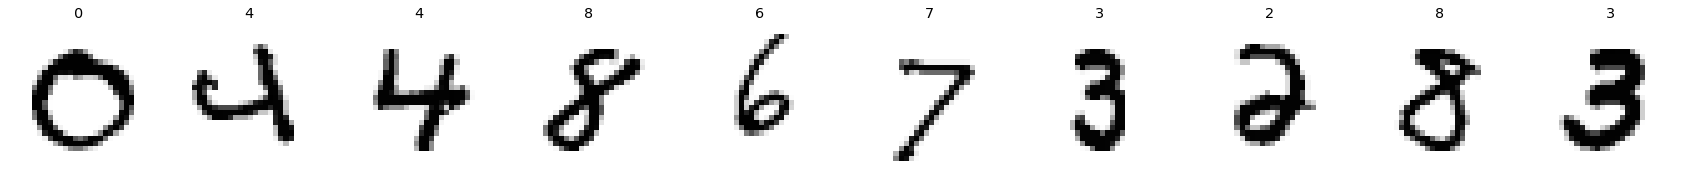

In [ ]:
dls.train.show_batch(max_n=10, nrows=1)

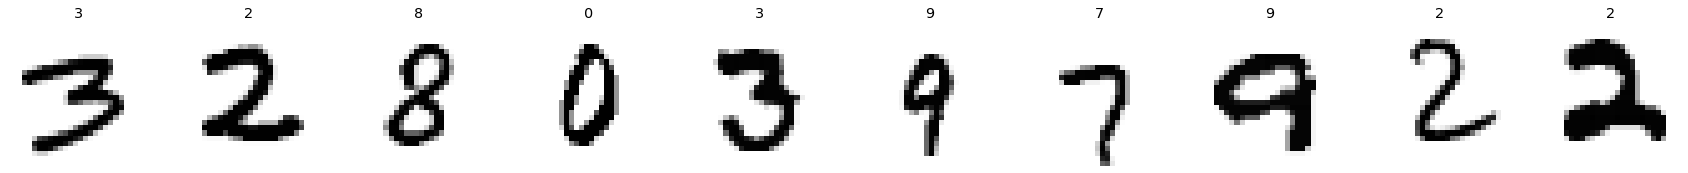

In [ ]:
dls.valid.show_batch(max_n=10, nrows=1)

In [ ]:
len(dls.train)

750

In [ ]:
len(dls.valid)

188

In [ ]:
x, y = first(dls.train)

In [ ]:
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
x[0].max()

TensorImageBW(1., device='cuda:0')

In [ ]:
loss = nn.CrossEntropyLoss()

def my_loss(i, t):
  i = cast(i, Tensor)
  t = cast(t, Tensor)
  return loss(i, t)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=my_loss, metrics=accuracy)

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 784            
Flatten                                                        
____________________________________________________________________________
                     64 x 30             
Linear                                    23550      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 10             
Linear                                    310        True      
____________________________________________________________________________

Total params: 23,860
Total trainable params: 23,860
Total non-trainable params: 0

Optimizer used: <function SGD at 0x7fdef121b820>
Loss function: <function my_loss at 0x7fdeb8c268b0>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

In [ ]:
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.299822,0.294222,0.915667,00:05
1,0.256010,0.244513,0.928833,00:05
2,0.198730,0.205681,0.940417,00:05
3,0.186619,0.186411,0.945667,00:05
4,0.166989,0.170371,0.951417,00:05
5,0.150694,0.158042,0.954583,00:05
6,0.130590,0.150575,0.956333,00:05
7,0.136826,0.145448,0.958167,00:05
8,0.124250,0.141563,0.958833,00:05
9,0.110068,0.134101,0.961833,00:05


In [ ]:
test_dl = learn.dls.test_dl(get_image_files(path/"testing"), with_labels=True)

In [ ]:
test_loss, test_accuracy = learn.validate(dl=test_dl)

In [ ]:
test_loss, test_accuracy

(0.1238597184419632, 0.9656999707221985)

In [ ]:
c = torch.zeros(1, requires_grad=True)
d = torch.zeros(1, requires_grad=True)

In [ ]:
def test_fn(params):
    for p in params:
        p.data += 1*p.grad
        p.grad.zero_()
        
        

In [ ]:
for i in range(4):
    x = c + d
    x.backward()
    test_fn([c, d])
    #print(c)
    print(c.data)
    print(c.grad.data)
    

tensor([1.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([3.])
tensor([0.])
tensor([4.])
tensor([0.])


In [ ]:
c

tensor([4.], requires_grad=True)

In [ ]:
d

tensor([4.], requires_grad=True)